In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from config import postgresPass as pw

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

In [3]:
import numpy as np
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, inspect

In [5]:
protocol = 'postgresql'
username = 'postgres'
password = pw
host = 'localhost'
port = 5432
database_name = 'bike_shop_pr3'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['customers',
 'combined_sales',
 'calendar',
 'products',
 'categories',
 'returns',
 'territories']

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['customers',
 'combined_sales',
 'calendar',
 'products',
 'categories',
 'returns',
 'territories']

In [9]:
# Get a list of column names and types for customers
customers_columns = inspector.get_columns('customers')
for c in customers_columns:
    print(c['name'], c["type"])

CustomerKey INTEGER
Prefix VARCHAR
FirstName VARCHAR
LastName VARCHAR
BirthDate VARCHAR
MaritalStatus VARCHAR
Gender VARCHAR
EmailAddress VARCHAR
AnnualIncome INTEGER
TotalChildren INTEGER
EducationLevel VARCHAR
Occupation VARCHAR
HomeOwner VARCHAR


In [10]:
# Save references to each table
customers = Base.classes.customers
sales = Base.classes.combined_sales
calendar = Base.classes.calendar
products = Base.classes.products
categories = Base.classes.categories
returns = Base.classes.returns
territories = Base.classes.territories

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.min(sales.OrderDate)).first()
most_recent_date

('2015-01-01',)

In [13]:
# Design a query to calculate the total number customers in the dataset
session.query(func.count(customers.CustomerKey)).all()

[(18148,)]

In [14]:
# Design a query to calculate the total number customers in each Education Level
result1 = session.query(customers.EducationLevel, func.count(customers.EducationLevel)).\
    group_by(customers.EducationLevel).order_by(func.count(customers.EducationLevel).desc()).all()

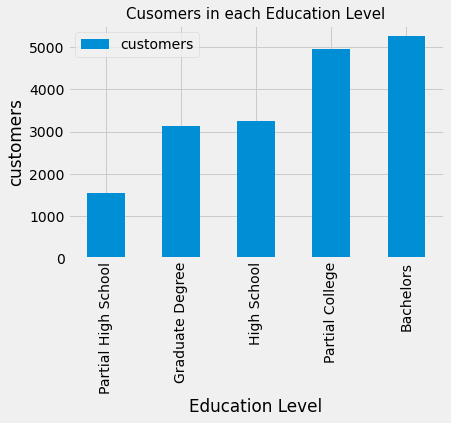

In [15]:
df1 = pd.DataFrame(result1)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df1 = pd.DataFrame(result1,columns=['Education Level', 'customers'])

# Sort the dataframe by date
df1 = df1.sort_values('customers')

# Use Pandas Plotting with Matplotlib to plot the data

df1.plot.bar(x='Education Level', y='customers', rot=90)
plt.xlabel("Education Level")
plt.ylabel("customers")

# Add title
plt.title("Cusomers in each Education Level", fontsize=15)

# Save to folder
plt.savefig("Resources/Education Level.png")

In [16]:
# Design a query to calculate the total number customers in each Annual Income bracket
result2 = session.query(customers.AnnualIncome, func.count(customers.AnnualIncome)).\
    group_by(customers.AnnualIncome).order_by(func.count(customers.AnnualIncome).desc()).all()

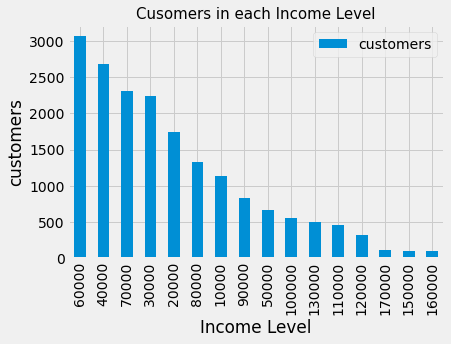

In [17]:
df2 = pd.DataFrame(result2)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df2 = pd.DataFrame(result2,columns=['Income Level', 'customers'])

# Use Pandas Plotting with Matplotlib to plot the data

df2.plot.bar(x='Income Level', y='customers', rot=90)
plt.xlabel("Income Level")
plt.ylabel("customers")

# Add title
plt.title("Cusomers in each Income Level", fontsize=15)

# Save to folder
plt.savefig("Resources/Income Level.png")

In [18]:
# Get a list of column names and types for products
product_columns = inspector.get_columns('products')
for p in product_columns:
    print(p['name'], p["type"])

ProductKey INTEGER
ProductSubcategoryKey INTEGER
ProductSKU VARCHAR
ProductName VARCHAR
ModelName VARCHAR
ProductDescription VARCHAR
ProductColor VARCHAR
ProductSize VARCHAR
ProductStyle VARCHAR
ProductCost INTEGER
ProductPrice INTEGER


In [19]:
# Design a query to calculate the total number of products in each product sub category
result3 = session.query(products.ProductSubcategoryKey, func.count(products.ProductSubcategoryKey)).\
    group_by(products.ProductSubcategoryKey).order_by(products.ProductSubcategoryKey).all()

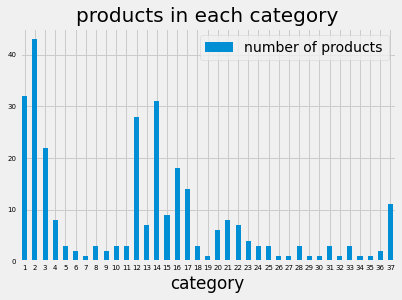

In [20]:
df3 = pd.DataFrame(result3)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df3 = pd.DataFrame(result3,columns=['category', 'number of products'])

# Use Pandas Plotting with Matplotlib to plot the data

df3.plot.bar(x='category', y='number of products',rot=0,fontsize=7 )
plt.xlabel("category")
# plt.ylabel("number of products")

# Add title
plt.title("products in each category", fontsize=20)

# Save to folder
plt.savefig("Resources/Categories.png")

In [21]:
all_sales_df = pd.read_sql_query(
    """
    SELECT
    "ProductKey",
    "CustomerKey",
    "SalesTerritoryKey",
    "OrderQuantity"
    FROM combined_sales
    """,
    con=engine)

In [22]:
all_sales_df

,ProductKey,CustomerKey,SalesTerritoryKey,OrderQuantity
0,332,14657,1,1
1,312,29255,4,1
2,350,11455,9,1
3,338,26782,6,1
4,312,14947,10,1
...,...,...,...,...
56041,477,28517,10,2
56042,479,28517,10,1
56043,606,28517,10,1
56044,480,21676,7,2


In [23]:
territories_df = pd.read_sql_query(
    """
    SELECT
    "SalesTerritoryKey",
    "Region",
    "Continent"
    FROM territories
    """,
    con=engine)

In [24]:
territories_df

,SalesTerritoryKey,Region,Continent
0,1,Northwest,North America
1,2,Northeast,North America
2,3,Central,North America
3,4,Southwest,North America
4,5,Southeast,North America
5,6,Canada,North America
6,7,France,Europe
7,8,Germany,Europe
8,9,Australia,Pacific
9,10,United Kingdom,Europe


In [25]:
all_sales_df1 = pd.merge(all_sales_df,territories_df, how="left",on='SalesTerritoryKey')

In [26]:
all_sales_df1

,ProductKey,CustomerKey,SalesTerritoryKey,OrderQuantity,Region,Continent
0,332,14657,1,1,Northwest,North America
1,312,29255,4,1,Southwest,North America
2,350,11455,9,1,Australia,Pacific
3,338,26782,6,1,Canada,North America
4,312,14947,10,1,United Kingdom,Europe
...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe
56042,479,28517,10,1,United Kingdom,Europe
56043,606,28517,10,1,United Kingdom,Europe
56044,480,21676,7,2,France,Europe


In [27]:
products_df = pd.read_sql_query(
    """
    SELECT
    "ProductKey",
    "ModelName",
    "ProductSubcategoryKey"
    FROM products
    """,
    con=engine)

In [28]:
products_df

,ProductKey,ModelName,ProductSubcategoryKey
0,214,Sport-100,31
1,215,Sport-100,31
2,218,Mountain Bike Socks,23
3,219,Mountain Bike Socks,23
4,220,Sport-100,31
...,...,...,...
288,602,ML Bottom Bracket,5
289,603,HL Bottom Bracket,5
290,604,Road-750,2
291,605,Road-750,2


In [29]:
all_sales_df2 = pd.merge(all_sales_df1,products_df, how="left",on='ProductKey')

In [30]:
all_sales_df2

,ProductKey,CustomerKey,SalesTerritoryKey,OrderQuantity,Region,Continent,ModelName,ProductSubcategoryKey
0,332,14657,1,1,Northwest,North America,Road-650,2
1,312,29255,4,1,Southwest,North America,Road-150,2
2,350,11455,9,1,Australia,Pacific,Mountain-100,1
3,338,26782,6,1,Canada,North America,Road-650,2
4,312,14947,10,1,United Kingdom,Europe,Road-150,2
...,...,...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe,Water Bottle,28
56042,479,28517,10,1,United Kingdom,Europe,Road Bottle Cage,28
56043,606,28517,10,1,United Kingdom,Europe,Road-750,2
56044,480,21676,7,2,France,Europe,Patch kit,37


In [31]:
categories_df = pd.read_sql_query(
    """
    SELECT
    "ProductSubcategoryKey",
    "CategoryName"
    FROM categories
    """,
    con=engine)

In [32]:
categories_df

,ProductSubcategoryKey,CategoryName
0,1,Bikes
1,2,Bikes
2,3,Bikes
3,4,Components
4,5,Components
5,6,Components
6,7,Components
7,8,Components
8,9,Components
9,10,Components


In [33]:
all_sales_df3 = pd.merge(all_sales_df2,categories_df, how="left",on='ProductSubcategoryKey')

In [34]:
all_sales_df3

,ProductKey,CustomerKey,SalesTerritoryKey,OrderQuantity,Region,Continent,ModelName,ProductSubcategoryKey,CategoryName
0,332,14657,1,1,Northwest,North America,Road-650,2,Bikes
1,312,29255,4,1,Southwest,North America,Road-150,2,Bikes
2,350,11455,9,1,Australia,Pacific,Mountain-100,1,Bikes
3,338,26782,6,1,Canada,North America,Road-650,2,Bikes
4,312,14947,10,1,United Kingdom,Europe,Road-150,2,Bikes
...,...,...,...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe,Water Bottle,28,Accessories
56042,479,28517,10,1,United Kingdom,Europe,Road Bottle Cage,28,Accessories
56043,606,28517,10,1,United Kingdom,Europe,Road-750,2,Bikes
56044,480,21676,7,2,France,Europe,Patch kit,37,Accessories


In [35]:
customers_df = pd.read_sql_query(
    """
    SELECT
    c."CustomerKey",
    c."Gender",
    c."EducationLevel",
    cs."CustomerKey",
    cs."SalesTerritoryKey"
    FROM customers AS c
    LEFT JOIN combined_sales AS cs
    ON c."CustomerKey" = cs."CustomerKey";
     
    """,
    con=engine)

In [36]:
customers_df

,CustomerKey,Gender,EducationLevel,CustomerKey,SalesTerritoryKey
0,14657,M,Partial College,14657.0,1.0
1,29255,M,Partial College,29255.0,4.0
2,11455,M,High School,11455.0,9.0
3,26782,M,High School,26782.0,6.0
4,14947,M,High School,14947.0,10.0
...,...,...,...,...,...
56773,28823,M,Graduate Degree,NaN,NaN
56774,20168,F,High School,NaN,NaN
56775,22217,M,Partial High School,NaN,NaN
56776,18013,F,Bachelors,NaN,NaN


In [37]:
all_sales_df4 = pd.merge(all_sales_df3,customers_df, how="left",on='CustomerKey')

ValueError: The column label 'CustomerKey' is not unique.

In [38]:
all_sales_df4

NameError: name 'all_sales_df4' is not defined

In [ ]:
all_sales_df4.pop('Continent')

In [ ]:
all_sales_df4.pop('SalesTerritoryKey')

In [ ]:
all_sales_df4.pop('ProductSubcategoryKey')

In [ ]:
all_sales_df4

In [ ]:
# Get all the data for Bikes. 
just_bikes_df = all_sales_df4.loc[all_sales_df4["CategoryName"] == "Bikes"]
just_bikes_df

In [ ]:
just_bikes_df.pop('ProductKey')

In [ ]:
just_bikes_df.pop('CustomerKey')

In [ ]:
just_bikes_df

In [ ]:
# Generate a pie plot showing the distribution of female versus male bike sales
counts = just_bikes_df.Gender.value_counts()
counts.plot(kind="pie",autopct='%1.1f%%')
plt.show()
# Save to folder
plt.savefig("Resources/bike_sales_gender.png")

In [ ]:
# Get model name data
model_data = just_bikes_df["ModelName"].value_counts()
model_data

In [ ]:
# Create plot
model_data.plot(kind="bar", facecolor="red", rot=45,figsize=(10,10) )

# Set title and axis labels
plt.title("Bike sales by Model Name")
plt.ylabel("Bike sales")
plt.xlabel("Model Name")

# Resize plot to display labels
plt.tight_layout()
plt.savefig("Resources/bike_sales_Model.png")

In [ ]:
# Get Education Level data
Education_data = just_bikes_df["EducationLevel"].value_counts()
Education_data

In [ ]:
# Create plot
Education_data.plot(kind="bar", facecolor="red", rot=90,figsize=(10,10) )

# Set title and axis labels
plt.title("Bike sales by Education Level")
plt.ylabel("Bike sales")
plt.xlabel("Education Level")

# Resize plot to display labels
plt.tight_layout()
plt.savefig("Resources/bike_sales_Education.png")

In [ ]:
# Close Session
session.close()